In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

import pandas as pd
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib
from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.dataset.scaler import StandardScaler

from lips.config import ConfigManager
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_neurips_2020_track1_small"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_neurips_2020_track1_small.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# 1. l2rpn_neurips_2020_track1_small grid

## 1.1 Benchmark1: Risk assessment through contingency screening

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark1", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
                       
kwargs_tau

[(1, (2, 2, 1, 1, 2, 2)),
 (16, (1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1)),
 (16, (1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)),
 (28, (2, 1, 2, 1, 1))]

### Tensorflow ResNet 

In [5]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                         bench_config_path=BENCH_CONFIG_PATH,
                         bench_config_name="Benchmark1",
                         topo_vect_to_tau="given_list",
                         kwargs_tau=kwargs_tau,
                         #layers = [600, 600, 600, 600, 600],
                         layers = [400, 400, 400],
                         scale_input_layer = True,
                         lr = 1e-4,
                                      
                         loss = {"name": "mse"},
                         layer = "resnet",
                         activation = "elu",
                         sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                         sim_config_name="DEFAULT",
                         log_path=LOG_PATH,
                         scaler = StandardScaler,
                                     
                                     )

In [6]:
import time
start_time = time.time()

In [7]:
tf_resnet.train(train_dataset=benchmark1.train_dataset,
            val_dataset=benchmark1.val_dataset,
            batch_size = 128,
            epochs=400)

2022-07-22 14:07:44.022142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:07:44.436304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:03:00.0, compute capability: 8.6


Epoch 1/400
  41/1172 [>.............................] - ETA: 4s - loss: 0.9379 - mae: 0.6874 

2022-07-22 14:07:47.047442: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 6s 5ms/step - loss: 0.1272 - mae: 0.2195 - val_loss: 0.0530 - val_mae: 0.1537
Epoch 2/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0304 - mae: 0.1142 - val_loss: 0.0298 - val_mae: 0.1147
Epoch 3/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0186 - mae: 0.0900 - val_loss: 0.0205 - val_mae: 0.0946
Epoch 4/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0134 - mae: 0.0772 - val_loss: 0.0164 - val_mae: 0.0847
Epoch 5/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0106 - mae: 0.0690 - val_loss: 0.0119 - val_mae: 0.0725
Epoch 6/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0088 - mae: 0.0631 - val_loss: 0.0111 - val_mae: 0.0706
Epoch 7/400
1172/1172 [==============================] - 5s 5ms/step - loss: 0.0074 - mae: 0.0579 - val_loss: 0.0098 - val_mae: 0.0655
Epoch 8/400
1172/1172 [==============================] - 5s 5ms/ste

1172/1172 [==============================] - 5s 5ms/step - loss: 7.0072e-04 - mae: 0.0169 - val_loss: 7.3552e-04 - val_mae: 0.0168
Epoch 120/400
1172/1172 [==============================] - 5s 5ms/step - loss: 5.9688e-04 - mae: 0.0158 - val_loss: 9.2277e-04 - val_mae: 0.0177
Epoch 121/400
1172/1172 [==============================] - 5s 5ms/step - loss: 6.4064e-04 - mae: 0.0163 - val_loss: 8.7882e-04 - val_mae: 0.0178
Epoch 122/400
1172/1172 [==============================] - 5s 5ms/step - loss: 6.4404e-04 - mae: 0.0163 - val_loss: 0.0017 - val_mae: 0.0228
Epoch 123/400
1172/1172 [==============================] - 5s 5ms/step - loss: 7.3909e-04 - mae: 0.0170 - val_loss: 9.2455e-04 - val_mae: 0.0185
Epoch 124/400
1172/1172 [==============================] - 5s 5ms/step - loss: 5.6913e-04 - mae: 0.0155 - val_loss: 0.0010 - val_mae: 0.0190
Epoch 125/400
1172/1172 [==============================] - 5s 5ms/step - loss: 7.2356e-04 - mae: 0.0171 - val_loss: 6.6381e-04 - val_mae: 0.0156
Epoch 1

1172/1172 [==============================] - 5s 5ms/step - loss: 5.4897e-04 - mae: 0.0148 - val_loss: 4.9759e-04 - val_mae: 0.0131
Epoch 177/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.6608e-04 - mae: 0.0137 - val_loss: 0.0013 - val_mae: 0.0227
Epoch 178/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.5574e-04 - mae: 0.0136 - val_loss: 5.4172e-04 - val_mae: 0.0145
Epoch 179/400
1172/1172 [==============================] - 5s 5ms/step - loss: 5.0778e-04 - mae: 0.0143 - val_loss: 5.8621e-04 - val_mae: 0.0152
Epoch 180/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.8319e-04 - mae: 0.0139 - val_loss: 5.5459e-04 - val_mae: 0.0145
Epoch 181/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.8790e-04 - mae: 0.0142 - val_loss: 5.9163e-04 - val_mae: 0.0149
Epoch 182/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.9002e-04 - mae: 0.0141 - val_loss: 9.6433e-04 - val_mae: 0.0174
Epo

Epoch 233/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.5932e-04 - mae: 0.0132 - val_loss: 4.6704e-04 - val_mae: 0.0127
Epoch 234/400
1172/1172 [==============================] - 5s 5ms/step - loss: 3.3961e-04 - mae: 0.0119 - val_loss: 7.6461e-04 - val_mae: 0.0167
Epoch 235/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.5204e-04 - mae: 0.0134 - val_loss: 5.4271e-04 - val_mae: 0.0140
Epoch 236/400
1172/1172 [==============================] - 5s 5ms/step - loss: 3.7779e-04 - mae: 0.0125 - val_loss: 4.9719e-04 - val_mae: 0.0141
Epoch 237/400
1172/1172 [==============================] - 5s 5ms/step - loss: 3.6874e-04 - mae: 0.0124 - val_loss: 6.0225e-04 - val_mae: 0.0148
Epoch 238/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.0660e-04 - mae: 0.0130 - val_loss: 7.2797e-04 - val_mae: 0.0170
Epoch 239/400
1172/1172 [==============================] - 5s 5ms/step - loss: 4.4527e-04 - mae: 0.0134 - val_loss: 5.6346e-04 - v

1172/1172 [==============================] - 5s 4ms/step - loss: 3.5076e-04 - mae: 0.0119 - val_loss: 4.9642e-04 - val_mae: 0.0132
Epoch 346/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.1523e-04 - mae: 0.0114 - val_loss: 3.3883e-04 - val_mae: 0.0112
Epoch 347/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.6047e-04 - mae: 0.0119 - val_loss: 4.7243e-04 - val_mae: 0.0125
Epoch 348/400
1172/1172 [==============================] - 5s 4ms/step - loss: 2.6652e-04 - mae: 0.0104 - val_loss: 4.7257e-04 - val_mae: 0.0134
Epoch 349/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.0883e-04 - mae: 0.0114 - val_loss: 3.7024e-04 - val_mae: 0.0117
Epoch 350/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.0295e-04 - mae: 0.0111 - val_loss: 3.5850e-04 - val_mae: 0.0115
Epoch 351/400
1172/1172 [==============================] - 5s 4ms/step - loss: 3.0039e-04 - mae: 0.0112 - val_loss: 4.3925e-04 - val_mae: 0.0127

In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2437.0440492630005 seconds ---


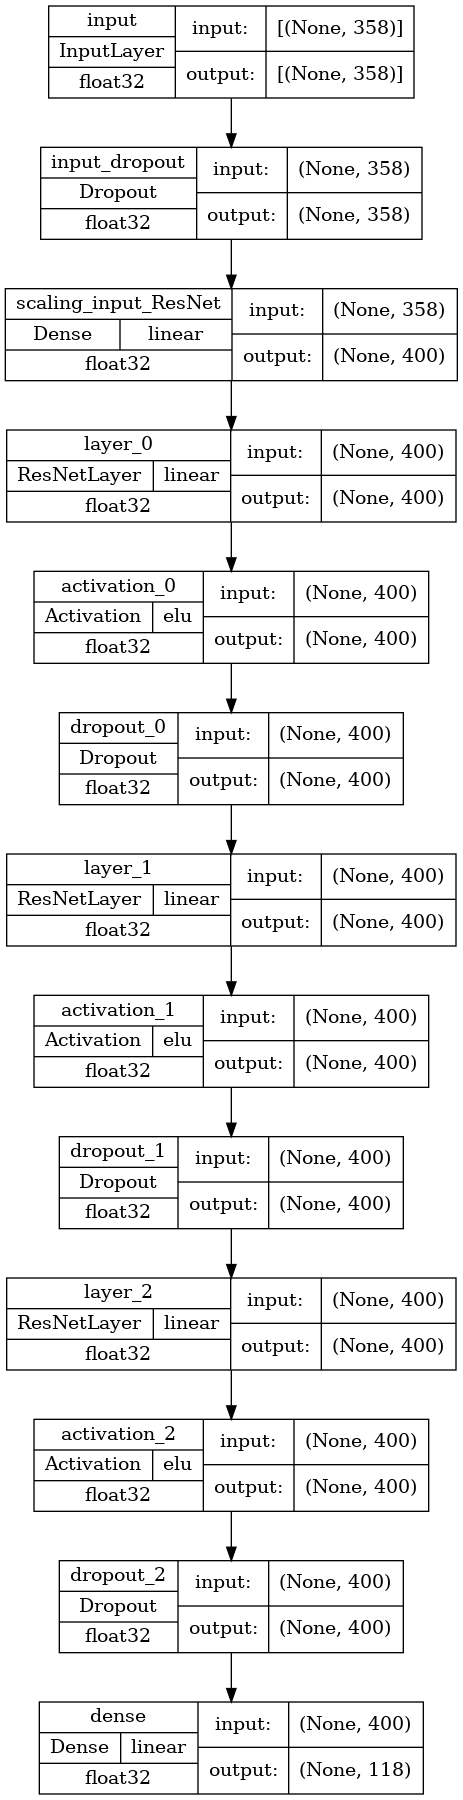

In [9]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [10]:
tf_resnet.summary()

Model: "tf_fc_DEFAULT_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 358)]             0         
                                                                 
 input_dropout (Dropout)     (None, 358)               0         
                                                                 
 scaling_input_ResNet (Dense  (None, 400)              143600    
 )                                                               
                                                                 
 layer_0 (ResNetLayer)       (None, 400)               320800    
                                                                 
 activation_0 (Activation)   (None, 400)               0         
                                                                 
 dropout_0 (Dropout)         (None, 400)               0         
                                               

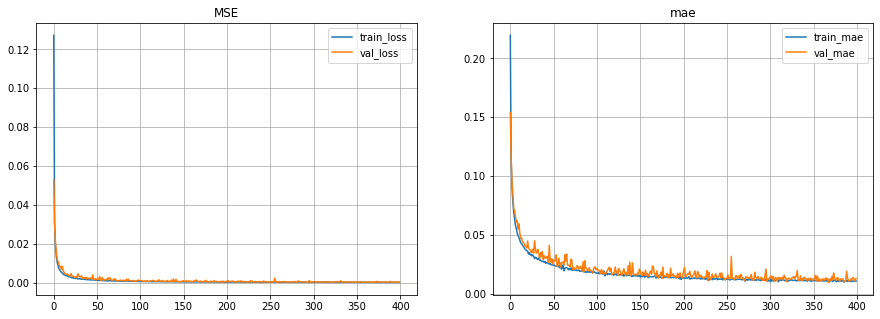

In [11]:
tf_resnet.visualize_convergence()

In [12]:
tf_fc_metrics1 = benchmark1.evaluate_simulator(augmented_simulator=tf_resnet,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


1/1 [==============================] - 0s 56ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 58ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


3/3 [==============================] - 0s 19ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
tf_resnet.save(SAVE_PATH)

In [14]:
import numpy as np
eval_metrics = tf_fc_metrics1

print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", tf_fc_metrics1["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))

testset_violoation = [tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

oodset_violoation = [tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))



ML : MAPE90 --> A : mean :0.0045988768630909425, std :3.7296062506879044e-05
ML : Inf speed-up : 0.3478495730087161
Rediness : Inf speed-up : 0.3615409720223397
OOD : MAPE90 --> A : mean :0.03996918263907405, std :0.00032946735550228035
Physics : test --> CURRENT_POS : mean :0.009929661016949153, std :5.0000000000000565e-05
Physics : ood --> CURRENT_POS : mean :0.00855220338983051, std :4.983050847457652e-05
